In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext snakeviz

import glob
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np
from hendrics.io import load_events, save_pds, load_pds
from stingray.gti import create_gti_from_condition, gti_border_bins, time_intervals_from_gtis, cross_two_gtis
from stingray.utils import show_progress
from stingray.fourier import avg_cs_from_events, avg_pds_from_events, poisson_level, get_average_ctrate
from stingray import AveragedPowerspectrum, AveragedCrossspectrum, EventList

# Spectral timing exploration

In this page, we will run a quicklook timing/spectral timing analysis of a NICER observation of an accreting black hole. We will not give a scientific interpretation, just pure exploration, showing off Stingray's capabilities.

## Load events and plot light curve

Let us take a look at the light curve

Text(0, 0.5, 'Counts/bin')

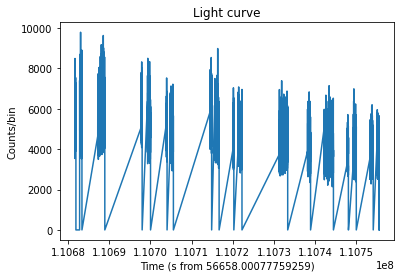

In [2]:
def load_and_cleanup_events(fname):
    """Load data and apply GTIs"""
    events = EventList.read(fname)
    lc = events.to_lc(dt=1)
    lc.apply_gtis()
    plt.figure()
    plt.plot(lc.time, lc.counts)

    new_gti = create_gti_from_condition(lc.time, lc.counts > 0, safe_interval=1)
    lc.gti = new_gti
    lc.apply_gtis()
    plt.plot(lc.time, lc.counts)
    plt.title("Light curve")
    plt.xlabel(f"Time (s from {events.mjdref})")
    plt.ylabel(f"Counts/bin")
    events.gti = new_gti
    return events

fname = "data.hdf5"

# Load events. NB. for standard FITS files from HEASARC, it would be
# events = EventList.read(fname, "hea")
events = EventList.read(fname)
events.fname = fname

# Create light curve and apply GTIs
lc = events.to_lc(dt=1)
lc.apply_gtis()
plt.figure()
plt.plot(lc.time, lc.counts)
plt.title("Light curve")
plt.xlabel(f"Time (s from {events.mjdref})")
plt.ylabel(f"Counts/bin")


The light curve has zeros where it should not have them. Let us define new GTIs avoiding these zeros.

In [3]:
new_gti = create_gti_from_condition(lc.time, lc.counts > 0, safe_interval=1)
lc.gti = new_gti
lc.apply_gtis()


Text(0, 0.5, 'Counts/bin')

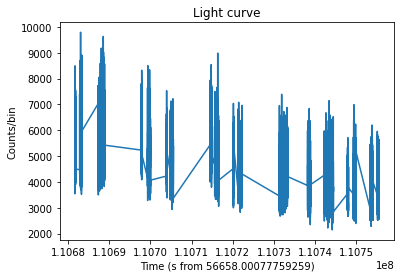

In [4]:
plt.figure()
plt.plot(lc.time, lc.counts)
plt.title("Light curve")
plt.xlabel(f"Time (s from {events.mjdref})")
plt.ylabel(f"Counts/bin")


Much better. Hereafter, we will use these new GTIs to process the data.

In [5]:
events.gti = new_gti


## Calculate periodogram and cross spectrum

Let us now take a look at the periodogram and the cross spectrum

In [6]:
# Calculate the periodogram in fractional rms normalization
segment_size=50
dt=0.001
norm="frac"
pds = AveragedPowerspectrum.from_events(events, segment_size=segment_size, dt=dt, norm=norm)

# Calculate the Poisson noise level
ctrate = get_average_ctrate(events.time, events.gti, segment_size)
noise = poisson_level(norm, meanrate=ctrate)

# Rebin the periodogam
pds_reb = pds.rebin_log(0.02)

285it [00:00, 305.45it/s]


Text(0, 0.5, '$\\mathrm{(rms / mean)^2}$')

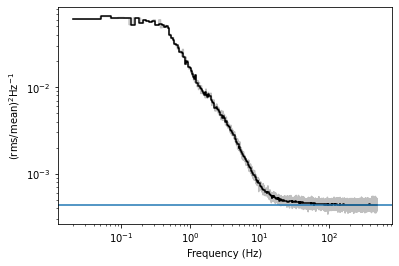

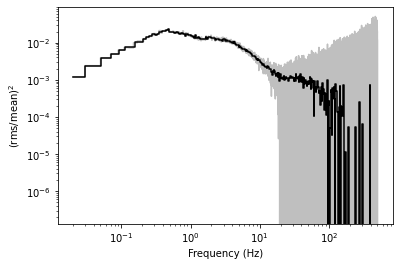

In [7]:
plt.figure()

plt.plot(pds.freq, pds.power, drawstyle="steps-mid", color="grey", alpha=0.5)
plt.plot(pds_reb.freq, pds_reb.power, drawstyle="steps-mid", color="k")
plt.axhline(noise)
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2 Hz^{-1}}$")

plt.figure()
plt.plot(pds.freq, (pds.power - noise) * pds.freq, drawstyle="steps-mid", color="grey", alpha=0.5)
plt.plot(pds_reb.freq, (pds_reb.power - noise) * pds_reb.freq, drawstyle="steps-mid", color="k")
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$")


And the cross spectrum between the bands 0.3--5 keV and 5--12 keV

In [8]:
ref_band = [5, 12]
sub_band = [0.3, 5]
events_ref = events.filter_energy_range(ref_band)
events_sub = events.filter_energy_range(sub_band)

cs = AveragedCrossspectrum.from_events(events_sub, events_ref, segment_size=segment_size, dt=dt, norm=norm)
cs_reb = cs.rebin_log(0.02)


285it [00:01, 202.98it/s]


Text(0, 0.5, '$\\mathrm{(rms / mean)^2}$')

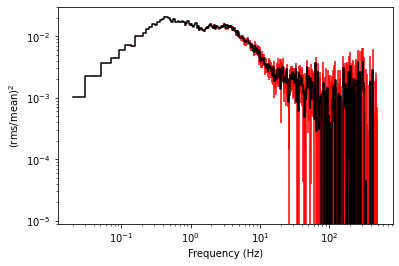

In [9]:
plt.figure()
# plt.plot(cs.freq, cs.power * cs.freq, drawstyle="steps-mid", color="grey", alpha=0.5)
plt.plot(cs_reb.freq, cs_reb.power * cs_reb.freq, drawstyle="steps-mid", color="k")
plt.errorbar(cs_reb.freq, cs_reb.power * cs_reb.freq, yerr=cs_reb.power_err * cs_reb.freq, fmt="none", color="r")
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$")


With the cross spectrum we can explore the time lags versus frequency

3644it [00:00, 3733.07it/s]


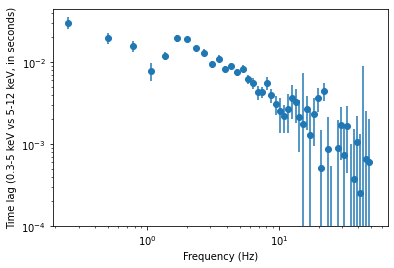

In [10]:
# Use shorter segments, rebin a little more heavily
cs = AveragedCrossspectrum.from_events(events_sub, events_ref, segment_size=4, dt=0.01, norm=norm)
cs_reb = cs.rebin_log(0.05)

lag, lag_e = cs_reb.time_lag()
plt.figure()
plt.errorbar(cs_reb.freq, lag, yerr=lag_e, fmt="o")
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"Time lag ({sub_band[0]:g}-{sub_band[1]:g} keV vs {ref_band[0]:g}-{ref_band[1]:g} keV, in seconds)")
plt.axhline(0, ls="--")
plt.loglog()
plt.ylim([1e-4, None]);
# plt.xlim([None, 80])
# plt.legend();

Another interesting thing to measure is the coherence at different frequencies

[]

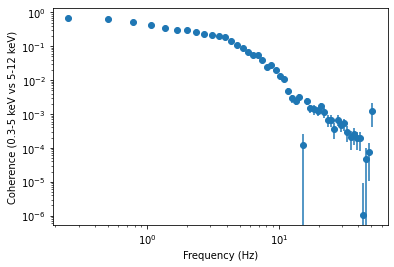

In [11]:
coh, coh_e = cs_reb.coherence()
plt.figure()
plt.errorbar(cs_reb.freq, coh, yerr=coh_e, fmt="o")
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"Coherence ({sub_band[0]:g}-{sub_band[1]:g} keV vs {ref_band[0]:g}-{ref_band[1]:g} keV)")
plt.axhline(0, ls="--")
plt.loglog()
# plt.ylim([1e-4, None]);
# plt.xlim([None, 80])
# plt.legend();

# Spectral timing

Now let us explore the spectral timing properties of this observation, with no physical interpretation, just for the sake of data exploration.

In [12]:
from stingray.varenergyspectrum import CountSpectrum, CovarianceSpectrum, RmsSpectrum, LagSpectrum

## Lags and coherence

Let us start with the lag spectrum with respect to energy, in different frequency bands.
This might be confusing for people coming from other wavelengths, so let us specify that

+ "frequency" refers to the frequency of the variability.

+ "energy" refers to the photon energy.

The photons at 0.3-12 keV are modulated by oscillations and other stochastic noise up to ~100 Hz (see section above). As an example, we will now analyze the spectral timing properties using the variability up to 1 Hz and between 4 and 10 Hz.

In [13]:
energy_spec = np.geomspace(0.3, 10, 31)
segment_size = 4
bin_time = 0.03
freq_interval = [0, 1]

# If not specified, the reference energy band is the whole band.

lagspec_0_1 = LagSpectrum(events, freq_interval=freq_interval, 
                          segment_size=segment_size, bin_time=bin_time,
                          energy_spec=energy_spec)
energies = np.mean(lagspec_0_1.energy_intervals, axis=1)



100%|██████████| 30/30 [00:34<00:00,  1.15s/it]


[]

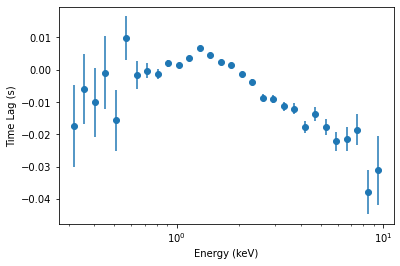

In [14]:
plt.figure()
plt.errorbar(energies, lagspec_0_1.spectrum, yerr=lagspec_0_1.spectrum_error, fmt='o', label="0-1 Hz")
plt.xlabel("Energy (keV)")
plt.ylabel("Time Lag (s)")
plt.semilogx()

In [15]:
lagspec_4_10 = LagSpectrum(events, freq_interval=[4, 10], 
                           segment_size=segment_size, bin_time=bin_time,
                           energy_spec=energy_spec)
energies = np.mean(lagspec_4_10.energy_intervals, axis=1)
energies_err = np.diff(lagspec_4_10.energy_intervals, axis=1).flatten() / 2



100%|██████████| 30/30 [00:35<00:00,  1.18s/it]


Text(0, 0.5, 'Time lag (s)')

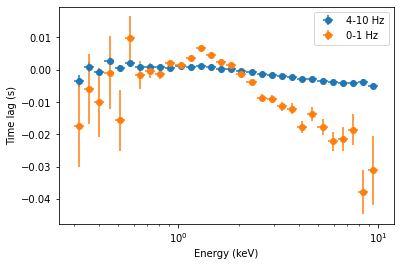

In [16]:
plt.figure()
plt.errorbar(energies, lagspec_4_10.spectrum, xerr=energies_err, yerr=lagspec_4_10.spectrum_error, fmt='o', label="4-10 Hz")
plt.errorbar(energies, lagspec_0_1.spectrum, xerr=energies_err, yerr=lagspec_0_1.spectrum_error, fmt='o', label="0-1 Hz")
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Time lag (s)")

Text(0, 0.5, 'Phase lag (s)')

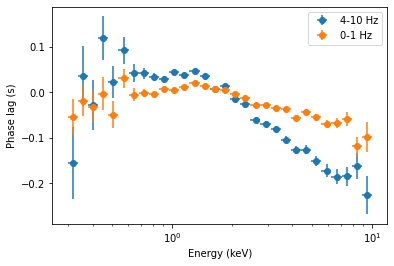

In [17]:
plt.figure()
plt.errorbar(energies, lagspec_4_10.spectrum * (2 * np.pi * 7), 
             xerr=energies_err, yerr=lagspec_4_10.spectrum_error * (2 * np.pi * 7), fmt='o', label="4-10 Hz")
plt.errorbar(energies, lagspec_0_1.spectrum * (2 * np.pi * 0.5), 
             xerr=energies_err, yerr=lagspec_0_1.spectrum_error * (2 * np.pi * 0.5), fmt='o', label="0-1 Hz")
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Phase lag (s)")

Interesting: the low-frequency variability has much longer time lags than the high-frequency variability, but the phase lags are on the same order of magnitude.

## Covariance and RMS spectrum

In [18]:
covspec_0_1 = CovarianceSpectrum(events, freq_interval=[0, 1], 
                                 segment_size=segment_size, bin_time=bin_time,
                                 energy_spec=energy_spec, norm="abs")
covspec_4_10 = CovarianceSpectrum(events, freq_interval=[4, 10], 
                                  segment_size=segment_size, bin_time=bin_time,
                                  energy_spec=energy_spec, norm="abs")


100%|██████████| 30/30 [00:45<00:00,  1.51s/it]


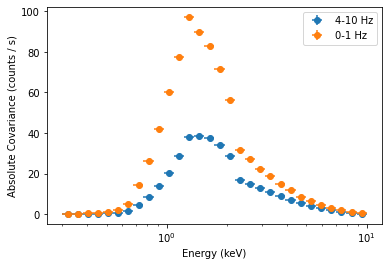

In [19]:
plt.figure()
plt.errorbar(energies, covspec_4_10.spectrum, 
             xerr=energies_err, yerr=covspec_4_10.spectrum_error, fmt='o', label="4-10 Hz")
plt.errorbar(energies, covspec_0_1.spectrum, 
             xerr=energies_err, yerr=covspec_0_1.spectrum_error, fmt='o', label="0-1 Hz")
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Absolute Covariance (counts / s)");

This covariance, plotted this way, mostly tracks the number of counts in each energy bin. To get an unfolded covariance, we need to use the response of the instrument. Another way is to plot the fractional covariance, normalizing by the number of counts in each bin.

To do this, we calculate the Count Spectrum and divide by it.

In [20]:
countsp = CountSpectrum(events, energy_spec=energy_spec)

30it [00:05,  5.15it/s]


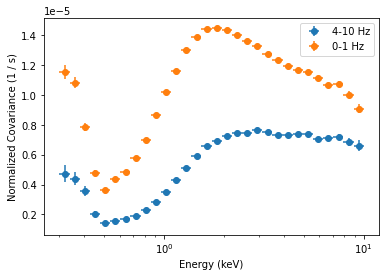

In [21]:
plt.figure()
plt.errorbar(energies, covspec_4_10.spectrum / countsp.spectrum, 
             xerr=energies_err, yerr=covspec_4_10.spectrum_error / countsp.spectrum, fmt='o', label="4-10 Hz")
plt.errorbar(energies, covspec_0_1.spectrum / countsp.spectrum, 
             xerr=energies_err, yerr=covspec_0_1.spectrum_error / countsp.spectrum, fmt='o', label="0-1 Hz")
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized Covariance (1 / s)");

Alternatively, we can calculate the Covariance Spectrum in fractional rms normalization

In [22]:
covspec_0_1 = CovarianceSpectrum(events, freq_interval=[0, 1], 
                                 segment_size=segment_size, bin_time=bin_time,
                                 energy_spec=energy_spec, norm="frac")
covspec_4_10 = CovarianceSpectrum(events, freq_interval=[4, 10], 
                                  segment_size=segment_size, bin_time=bin_time,
                                  energy_spec=energy_spec, norm="frac")


100%|██████████| 30/30 [00:33<00:00,  1.13s/it]


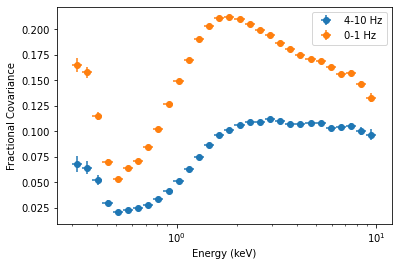

In [23]:
plt.figure()
plt.errorbar(energies, covspec_4_10.spectrum, 
             xerr=energies_err, yerr=covspec_4_10.spectrum_error, fmt='o', label="4-10 Hz")
plt.errorbar(energies, covspec_0_1.spectrum, 
             xerr=energies_err, yerr=covspec_0_1.spectrum_error, fmt='o', label="0-1 Hz")
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Fractional Covariance");

This should largely be equivalent to the RMS spectrum

In [24]:
rmsspec_0_1 = RmsSpectrum(events, freq_interval=[0, 1], 
                          segment_size=segment_size, bin_time=bin_time,
                          energy_spec=energy_spec, norm="frac")
rmsspec_4_10 = RmsSpectrum(events, freq_interval=[4, 10], 
                           segment_size=segment_size, bin_time=bin_time,
                           energy_spec=energy_spec, norm="frac")


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]


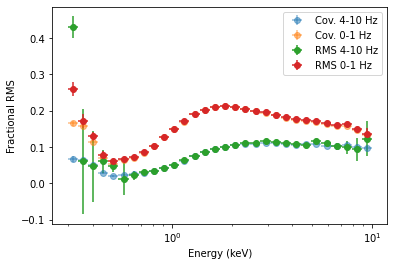

In [25]:
plt.figure()
plt.errorbar(energies, covspec_4_10.spectrum, 
             xerr=energies_err, yerr=covspec_4_10.spectrum_error, fmt='o', label="Cov. 4-10 Hz", alpha=0.5)
plt.errorbar(energies, covspec_0_1.spectrum, 
             xerr=energies_err, yerr=covspec_0_1.spectrum_error, fmt='o', label="Cov. 0-1 Hz", alpha=0.5)
plt.errorbar(energies, rmsspec_4_10.spectrum, 
             xerr=energies_err, yerr=rmsspec_4_10.spectrum_error, fmt='o', label="RMS 4-10 Hz")
plt.errorbar(energies, rmsspec_0_1.spectrum, 
             xerr=energies_err, yerr=rmsspec_0_1.spectrum_error, fmt='o', label="RMS 0-1 Hz")
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Fractional RMS");

QED, except that the error bars in some points look underestimated. It is always recommended to test error bars with simulations, in any case, as analytic formulas are based on a series of assumptions (in particular, on the coherence) that might not be correct in real life.